# Playing with Weakly nonlinear MHD
Let's play with a much simpler weakly nonlinear analysis than the MRI to get a feel for normalizing things. We choose Hartmann flow, following the paper by Hagen & Priede (2013), arXiv:1209.2409v3.

They use the z-velocity, $w$, instead of the streamfunction $\phi$ in order to construct the linear eigenvalue problem for the first order solution. We assume the solution can be separated into the form

$w(x,z,t) = \hat{w}(z) e^{\sigma t + i \alpha x}$,

with $\sigma = \gamma + i \omega$ and $\gamma$ and $\omega$ are both purely real.

NB: there's a pretty bad typo in their paper.

In [1]:
%matplotlib nbagg

/Users/susanclark/dedalus_upgraded/dedalus/lib/python3.4/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
#from dedalus.tools.config import config
#config['linear algebra']['use_baleig'] ='True'

In [3]:
import logging

root = logging.root
for h in root.handlers:
    h.setLevel("INFO")

In [4]:
import dedalus.public as de
import numpy as np
import matplotlib.pylab as plt

In [5]:
plt.style.use('ggplot')

In [6]:
nz = 100
z = de.Chebyshev('z',nz)
d = de.Domain([z])

First, we'll do plain Poiseuille flow, Ha = 0. We'll use the known critical parameters for $\mathrm{Re}_c$ and $\alpha_c$, where the latter is the critical horizontal wavenumber. 

In [7]:
alpha = 1.02056
Re = 5772.22

In [8]:
orr_somerfeld = de.EVP(d,['w','wz','wzz','wzzz'],'sigma')
orr_somerfeld.parameters['alpha'] = alpha
orr_somerfeld.parameters['Re'] = Re

2016-04-18 14:34:13,647 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10


In [9]:
orr_somerfeld.add_equation('dz(wzzz) - 2*alpha**2*wzz + alpha**4*w - sigma*(wzz-alpha**2*w)-1j*alpha*(Re*(1-z**2)*(wzz-alpha**2*w) + 2*Re*w) = 0 ')
orr_somerfeld.add_equation('dz(w)-wz = 0')
orr_somerfeld.add_equation('dz(wz)-wzz = 0')
orr_somerfeld.add_equation('dz(wzz)-wzzz = 0')

In [10]:
orr_somerfeld.add_bc('left(w) = 0')
orr_somerfeld.add_bc('right(w) = 0')
orr_somerfeld.add_bc('left(wz) = 0')
orr_somerfeld.add_bc('right(wz) = 0')

In [11]:
solver = orr_somerfeld.build_solver()

In [12]:
solver.solve(solver.pencils[0])

/Users/susanclark/dedalus_upgraded/dedalus/lib/python3.4/site-packages/scipy/linalg/decomp.py:56: RuntimeWarning: divide by zero encountered in true_divide
  w = alpha / beta
/Users/susanclark/dedalus_upgraded/dedalus/lib/python3.4/site-packages/scipy/linalg/decomp.py:56: RuntimeWarning: invalid value encountered in true_divide
  w = alpha / beta


We sort the eigenvalues by using `argsort()`. However, this includes all the masked elements, shoving them to the end of the array. We'll correct for this when we use it later.

In [13]:
ev = solver.eigenvalues
eigenvalues_keys = solver.eigenvalues.argsort()

In [14]:
marginal_mode_index = np.where(ev.real == np.max(ev.real))[0][0]
print("eigenvalue of marginal mode = {0:10.5e} at index {1:n}.".format(ev[marginal_mode_index],marginal_mode_index)
)
print(ev[eigenvalues_keys[400-ev.mask.sum()-2]]/Re)

eigenvalue of marginal mode =   inf+infj at index 2.


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

In [15]:
omega0 = ev[marginal_mode_index].imag

## Plot Eigenvalues
Note that Hagen & Priede use a non-standard version of the Orr-Somerfeld equation, so we need to divide by Re to get the standard values.

Weirdness: to get proper spectrum, need at least nz = 80, but get right critical value nz = 50. Looks like this is because the higher eigenvalues (which have higher damping rates) just aren't resolved well.

<IPython.core.display.Javascript object>


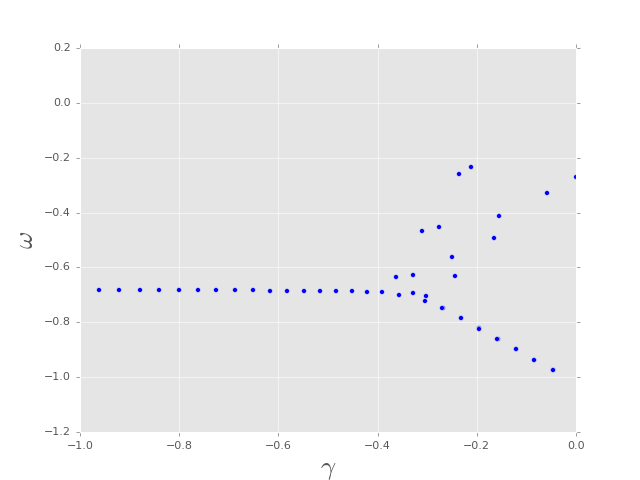

/home/jsoishi/tmp/dedalus-exp/lib/python3.4/site-packages/numpy/ma/core.py:806: RuntimeWarning: invalid value encountered in absolute
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)
/home/jsoishi/tmp/dedalus-exp/lib/python3.4/site-packages/numpy/ma/core.py:806: RuntimeWarning: invalid value encountered in greater_equal
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)


In [16]:
plt.figure()
plt.scatter(ev.real/Re,ev.imag/Re)
plt.xlim(-1,0)
#plt.ylim(-1,-0.2)
plt.xlabel(r"$\gamma$",fontsize=24)
plt.ylabel(r"$\omega$",fontsize=24)

## Plot Eigenvector of marginal mode

In [17]:
zz  = z.grid()
evector = solver.eigenvectors[marginal_mode_index]

First call up a mode to check orthogonality against the adjoint solution later. Any mode except the marginal one is fine.

To call up another mode, we work backwards from the largest real part by subtracting the sum of the mask (the total number of NaNs and infs) the number of total modes ($= N_z N_{vars}$, where $N_{vars} = 4$ for Orr Sommerfeld). Then, we subtract whatever mode we want to walk back from the critical mode (which will be -1).

In [77]:
other_mode_index = 4*nz-ev.mask.sum()-4
print("setting state to eigenvalue = {0:10.5e}".format(ev[eigenvalues_keys[other_mode_index]]/Re))
solver.set_state(eigenvalues_keys[other_mode_index])
data_2 = solver.state
w2 = data_2['w']['g'].copy()
w2zz = data_2['wz']['g'].copy()
w20 = w2.max()

setting state to eigenvalue = -5.87921e-02-3.27770e-01j


Because we use the data object in many subsequent calculations, we reset the solver state to the marginal mode.

In [71]:
solver.set_state(marginal_mode_index)
data = solver.state
w = data['w']
w0 = w.interpolate(z=0)['g'][0]

<IPython.core.display.Javascript object>


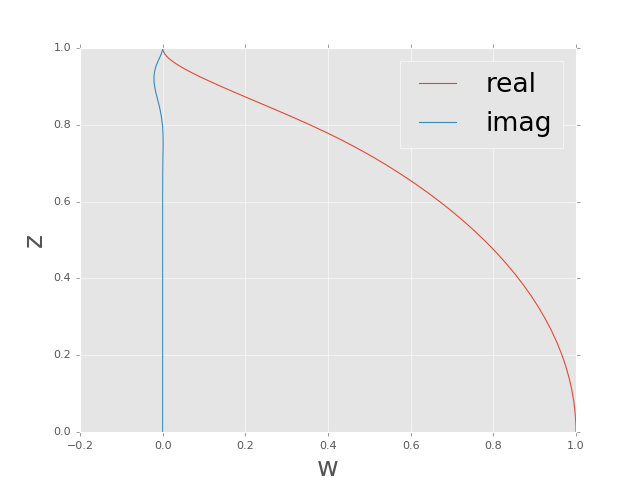

In [72]:
plt.figure()
plt.plot((data['w']['g']/w0).real,zz,label='real')
plt.plot((data['w']['g']/w0).imag,zz,label='imag')
#plt.plot((w2/w20).real,zz)
plt.legend(loc='upper right',fontsize=24)
plt.ylim(0,1)
plt.xlabel('w',fontsize=24)
plt.ylabel('z',fontsize=24)

<IPython.core.display.Javascript object>


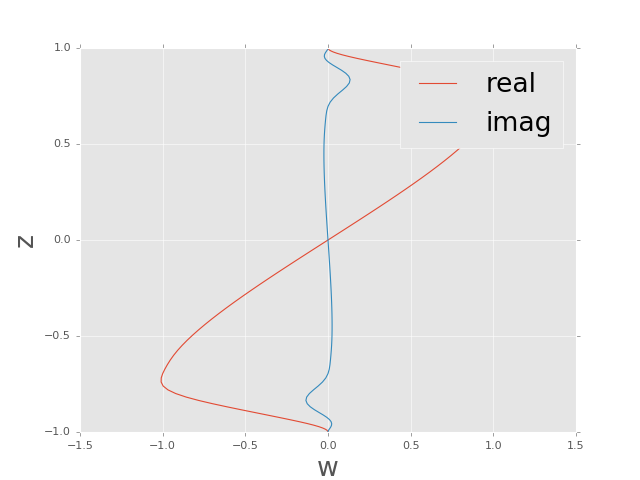

In [73]:
plt.figure()
plt.plot((w2/w20).real,zz,label='real')
plt.plot((w2/w20).imag,zz,label='imag')
plt.legend(loc='upper right',fontsize=24)
#plt.ylim(0,1)
plt.xlabel('w',fontsize=24)
plt.ylabel('z',fontsize=24)

### Antidifferentiate

Using Dedalus's ability to construct indefinite integrals by antidifferentiation, we integrate $w_z$ to get $w$, subject to the same boundary condition (this is equivalent to setting the constant of integration) as $w$.

In [21]:
wz = data['wz']

In [22]:
ww = wz.antidifferentiate(z,("left",0))

INFO:pencil:Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+02/s


2016-03-25 16:49:29,475 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+02/s


Because antidifferentiation is a linear operator, we can normalize either before *or* after. Here, we normalize afterwards. Plotting the integral of $w_z$ over $w$ from the eigenvalue solver, with both normalized by $w_0$, we see that $w_z$ indeed integrates to $w$, thus proving that by normalizing all variables in the state vector by the same value, we get the correct results. 

<IPython.core.display.Javascript object>


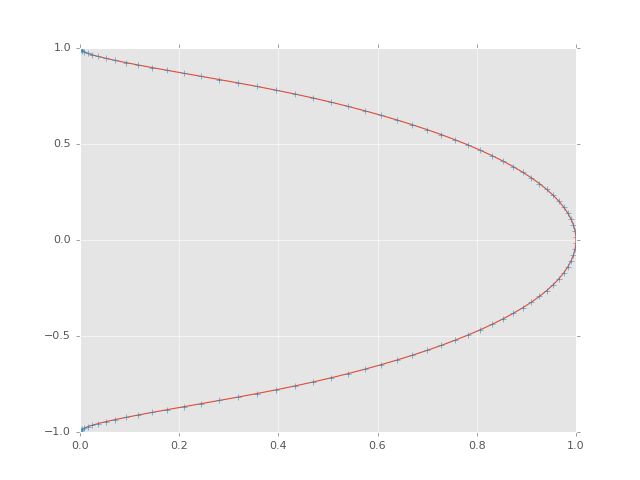

In [23]:
plt.figure()
plt.plot((ww['g']/w0).real,zz)
plt.plot((data['w']['g']/w0).real,zz,'+')

## Non-linear analysis

Here, we add the second ($O(\epsilon^2)$) and third order ($O(\epsilon^3)$). We've already solved for the linear response $\hat{w}_{1,1}$. We need to solve for the second order responses $\hat{w}_{2,2}$ and $\hat{u}_{0,2}$. Then, we use these to construct the right hand side of the $O(\epsilon^3)$ equation, which we then impose a solvability constraint on.

### $O(\epsilon^2)$

In [24]:
order1_data = solver.state
w = order1_data['w']
wz = order1_data['wz']
wzz = order1_data['wzz']

term1 = d.new_field()
term2 = d.new_field()
term1['g'] = (w['g']/w0)*(wz['g']/w0)
term2['g'] = (term1.differentiate("z")['g'] - 2*(wz['g']/w0)**2)
term2 = 2*term2.differentiate('z')

u_term = d.new_field()

In [25]:
order1_data = solver.state
w = order1_data['w']
wz = order1_data['wz']
wzz = order1_data['wzz']

term1 = d.new_field()
term2 = d.new_field()
term1['g'] = (w['g']/w0)*(wz['g']/w0)
term2['g'] = (term1.differentiate("z")['g'] - 2*(wz['g']/w0)**2)
term2 = 2*term2.differentiate('z')

u_term = d.new_field()
u_term['g'] = -2*((w['g']/w0).conj() * (wzz['g']/w0)).imag/alpha

In [26]:
order2 = de.LBVP(d,['w22','w22z','w22zz','w22zzz','u02','u02z'])
order2.parameters['alpha'] = alpha
order2.parameters['Re0'] = Re
order2.parameters['omega0'] = omega0
order2.parameters['RHS'] = term2
order2.parameters['RHS_u'] = u_term

order2.add_equation("dz(w22zzz) - 8*alpha**2*w22zz + 16*alpha**4*w22 - 2*1j*omega0*w22zz + 8*1j*omega0*alpha**2*w22 - 2*1j*alpha*Re0*(1-z**2)*w22zz+ 8*1j*alpha**3*Re0*(1-z**2)*w22 -4*1j*alpha*Re0*w22 = RHS")
order2.add_equation("dz(w22) - w22z = 0")
order2.add_equation("dz(w22z) - w22zz = 0")
order2.add_equation("dz(w22zz) - w22zzz = 0")
order2.add_equation("dz(u02z) = RHS_u")
order2.add_equation("dz(u02) - u02z = 0")

order2.add_bc('left(w22) = 0')
order2.add_bc('right(w22) = 0')
order2.add_bc('left(w22z) = 0')
order2.add_bc('right(w22z) = 0')
order2.add_bc('left(u02) = 0')
order2.add_bc('right(u02) = 0')


In [27]:
order2_solver = order2.build_solver()

INFO:pencil:Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.1e+01/s


2016-03-25 16:49:29,653 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.1e+01/s


In [28]:
order2_solver.solve()

<IPython.core.display.Javascript object>


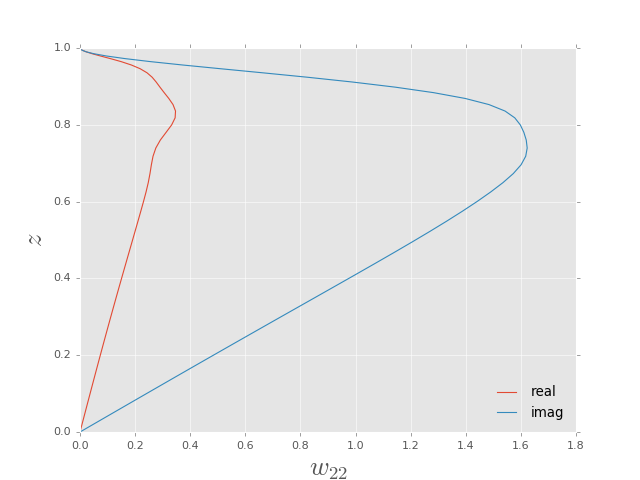

In [29]:
plt.figure()
plt.plot(order2_solver.state['w22']['g'].real*1e3,zz,label='real')
plt.plot(order2_solver.state['w22']['g'].imag*1e3,zz,label='imag')
plt.ylim(0,1)
plt.xlim(0,1.8)
plt.xlabel("$w_{22}$",fontsize=24)
plt.ylabel("$z$",fontsize=24)
plt.legend(loc='lower right').draw_frame(False)

<IPython.core.display.Javascript object>


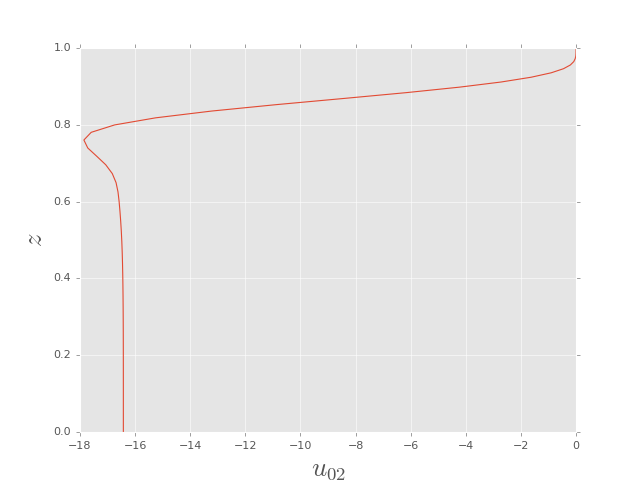

In [30]:
plt.figure()
plt.plot(order2_solver.state['u02']['g'].real*1e3,zz)
plt.ylim(0,1)
plt.xlim(-18,0)
plt.xlabel("$u_{02}$",fontsize=24)
plt.ylabel("$z$",fontsize=24)

### Adjoint Solution $\mathbf{V}^\dagger$

In [31]:
adjoint = de.EVP(d,['wa','waz','wazz','wazzz'], 'sigma')
adjoint.parameters['alpha'] = alpha
adjoint.parameters['Re'] = Re

adjoint.add_equation('dz(wazzz) - 2*alpha**2*wazz + alpha**4*wa + (1j*alpha*Re*(1-z**2) - sigma)*(wazz-alpha**2*wa)-4*1j*alpha*Re*z*waz = 0 ')
adjoint.add_equation('dz(wa)-waz = 0')
adjoint.add_equation('dz(waz)-wazz = 0')
adjoint.add_equation('dz(wazz)-wazzz = 0')
adjoint.add_bc('left(wa) = 0')
adjoint.add_bc('right(wa) = 0')
adjoint.add_bc('left(waz) = 0')
adjoint.add_bc('right(waz) = 0')

INFO:problems:Solving EVP with homogeneity tolerance of 1.000e-10


2016-03-25 16:49:29,795 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10


In [32]:
adjoint_solver = adjoint.build_solver()

In [33]:
adjoint_solver.solve(adjoint_solver.pencils[0])

In [34]:
aev = adjoint_solver.eigenvalues
marginal_adjmode_index = np.where(aev.real == np.max(aev.real))[0][0]

<IPython.core.display.Javascript object>


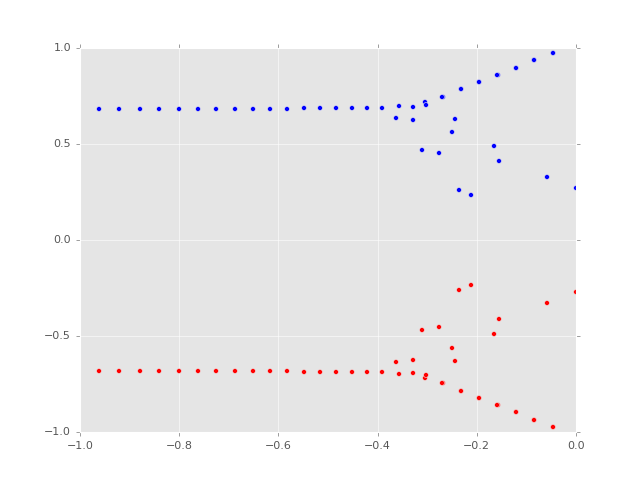

(-1, 1)

In [88]:
plt.figure()
plt.scatter(aev.real/Re,aev.imag/Re)
plt.scatter(ev.real/Re,ev.imag/Re,c='r')
#plt.xlim(0,1)
plt.xlim(-1,0)
plt.ylim(-1,1)

Now we look at the residual

<IPython.core.display.Javascript object>


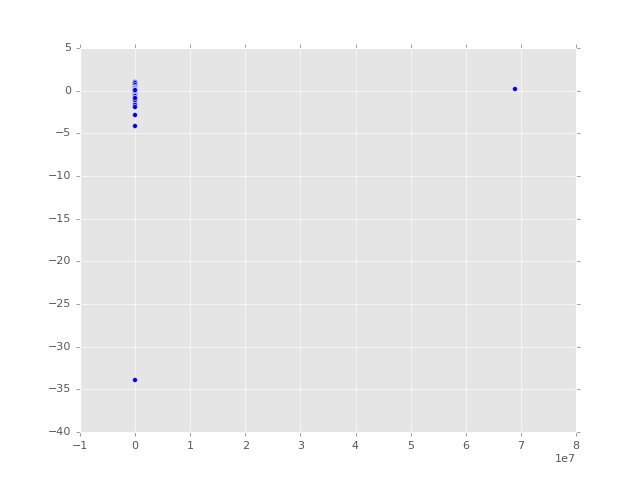

In [95]:
plt.figure()
plt.scatter((aev.real-ev.real)/ev.real,(aev.imag+ev.imag)/ev.imag)
#plt.xlim(-1e-2,1e-2)
#plt.ylim(-1e-2,1e-2)

In [36]:
adjoint_solver.set_state(marginal_adjmode_index)
adj_data = adjoint_solver.state
wa = adj_data['wa']

Normalize by setting $\left< w^\dagger, (\partial_z^2 w - \alpha^2 w)\right> = 1$

In [37]:
wa0 = d.new_field()

wa0['g'] = wa['g'] * (wzz['g']/w0 - alpha**2 * w['g']/w0)

wa0_norm = wa0.integrate()['g'][0]
print("wa0_norm = {0:10.5e}".format(wa0_norm))

wa0_norm = 1.15931e-04+4.40887e-04j


Now, test orthogonality

In [38]:
orth_test = d.new_field()
orth_test['g'] = (wa['g']/wa0_norm * (wzz['g']/w0 - alpha**2 * w['g']/w0))
orth_test.integrate("z")['g'][0]

(0.99999999999999978+7.0474374146013687e-17j)

In [74]:
orth_test2 = d.new_field()
orth_test2['g'] = (wa['g']/wa0_norm * (w2zz/w20 - alpha**2 * w2/w20))
orth_test2.integrate("z")['g'][0]

(-0.17507182517867551-0.42000807110899474j)

<IPython.core.display.Javascript object>


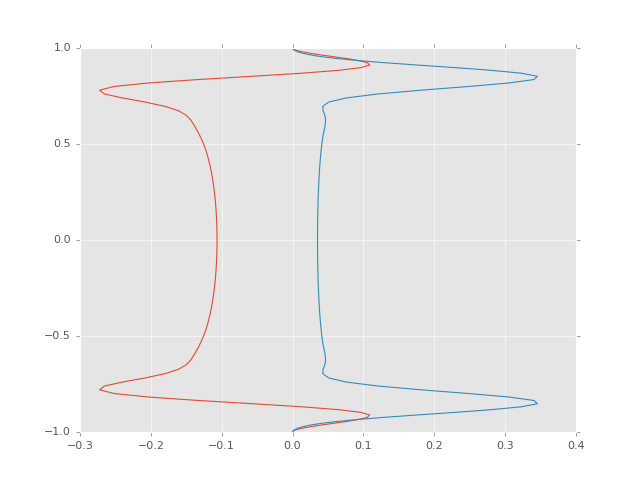

In [75]:
plt.figure()
plt.plot((wa['g']/wa0_norm).real,zz)
plt.plot((wa['g']/wa0_norm).imag,zz)
#plt.ylim(0,1)

# Now, we compare to the data in Hagan & Priede:

$\mu_1 = 0.0097118 - i0.222596$

$\mu_2 = 0.0049382 - i0.0239131$

In [41]:
mu1 = d.new_field()
mu1['g'] = -((wa0['g']/wa0_norm) * 1j*alpha*((1-zz**2)*(wzz['g']/w0-alpha**2*w['g']/w0)+2*w['g']/w0) )
print(mu1.integrate()['g'][0])

(0.424727702606+1.34578990593j)
